# Rest vs. Exercise

If you are in this notebook, it means you have passed through the previous notebooks explaining different techniques. In all of them, we have mentioned a brief comparison between data when the subject is at rest and when the person has just finished performing an exercise. In this notebook, we bring all these techniques together. What information will we be able to obtain from them?

From an electrocardiogram, we can obtain two time series: the same electrocardiogram and R-R intervals. Techniques using the R-R interval time series:

*  Standard technique: R-R intervals and QRS complex

*  Poincaré plots

Techniques using the R-R interval time series:

*  Phase space reconstruction

*  Recurrence plot

# Setting up the notebook

We begin by setting up the Jupyter notebook and importing the Python modules needed for plotting figures, create animations, etc. We include commands to view plots in the Jupyter notebook, and to create figures with good resolution and large labels. These commands can be customized to produce figures with other specifications.

In [1]:
# Imports python libraries
import numpy as np
import random as rd
import wave
import sys
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from statistics import stdev
sys.path.insert(1, r'./../functions') # add to pythonpath

# commands to create high-resolution figures with large labels
%config InlineBackend.figure_formats = {'png', 'retina'} 
plt.rcParams['axes.labelsize'] = 16 # fontsize for figure labels
plt.rcParams['axes.titlesize'] = 18 # fontsize for figure titles
plt.rcParams['font.size'] = 14 # fontsize for figure numbers
plt.rcParams['lines.linewidth'] = 1.4 # line width for plotting

## Extracting data

ECG recordings were obtained using the Backyard Brains Heart and Brain Spiker Box. The recordings are saved as audio files in .wav format. The first thing we have to do is open the .wav files and extract the data. We can extract the number of recording channels, sampling rate, etc. This is done in the following function.

In [2]:
#Function that extracts the number of recording channels, sampling rate, time and signal
#variable is the path and filename of the .wav file
def ecg(variable):
    record = wave.open(variable, 'r') # load the data

    # Get the number of channels, sample rate, etc.
    numChannels = record.getnchannels() #number of channels
    numFrames = record.getnframes() #number of frames
    sampleRate = record.getframerate() #sampling rate
    sampleWidth = record.getsampwidth()
    
    # Get wave data
    dstr = record.readframes(numFrames * numChannels)
    waveData = np.frombuffer(dstr, np.int16)

    # Get time window
    timeECG = np.linspace(0, len(waveData)/sampleRate, num=len(waveData))

    return timeECG, waveData

# R peaks

Function for detecting R peaks. We will be able to calculate heart frequency and R-R intervals.

The following function creates an array of values which surpass a certain threshold. Afterwards, it determines the maximum value of this array and adds it in the R-vector. And this is repeated until the end of the time series.

In [3]:
def detecta_maximos_locales(timeECG, waveData, threshold_ratio=0.7):
    # If not all the R peaks are detected, lower the threshold_ratio
    # If components that are not R peaks (like T waves) are detected, higher the threshold_ratio

    if len(timeECG) != len(waveData): #Raises an error if the two arrays have different lengths
        raise Exception("The two arrays have different lengths.")
    
    interval = max(waveData) - min(waveData)
    threshold = threshold_ratio*interval + min(waveData)
    maxima = []
    maxima_indices = []
    mxs_indices = []
    banner = False
    
    for i in range(0, len(waveData)):
            
        if waveData[i] >= threshold:#If a threshold value is surpassed,
            # the indices and values are saved 
            banner = True
            maxima_indices.append(i)
            maxima.append(waveData[i])
            
        elif banner == True and waveData[i] < threshold: #If the threshold value is crossed
            # the index of the maximum value in the original array is saved
            index_local_max = maxima.index(max(maxima))
            mxs_indices.append(maxima_indices[index_local_max])
            maxima = []
            maxima_indices = []
            banner = False     

    return mxs_indices

Running the previous code with test data of a subject at rest. This recording will be referred to throughout the notebook as ``rest``.

In [5]:
timeECG_rest, waveData_rest = ecg("ECG_samples/S1_rest.wav")
mxs_indices_rest = detecta_maximos_locales(timeECG_rest, waveData_rest)

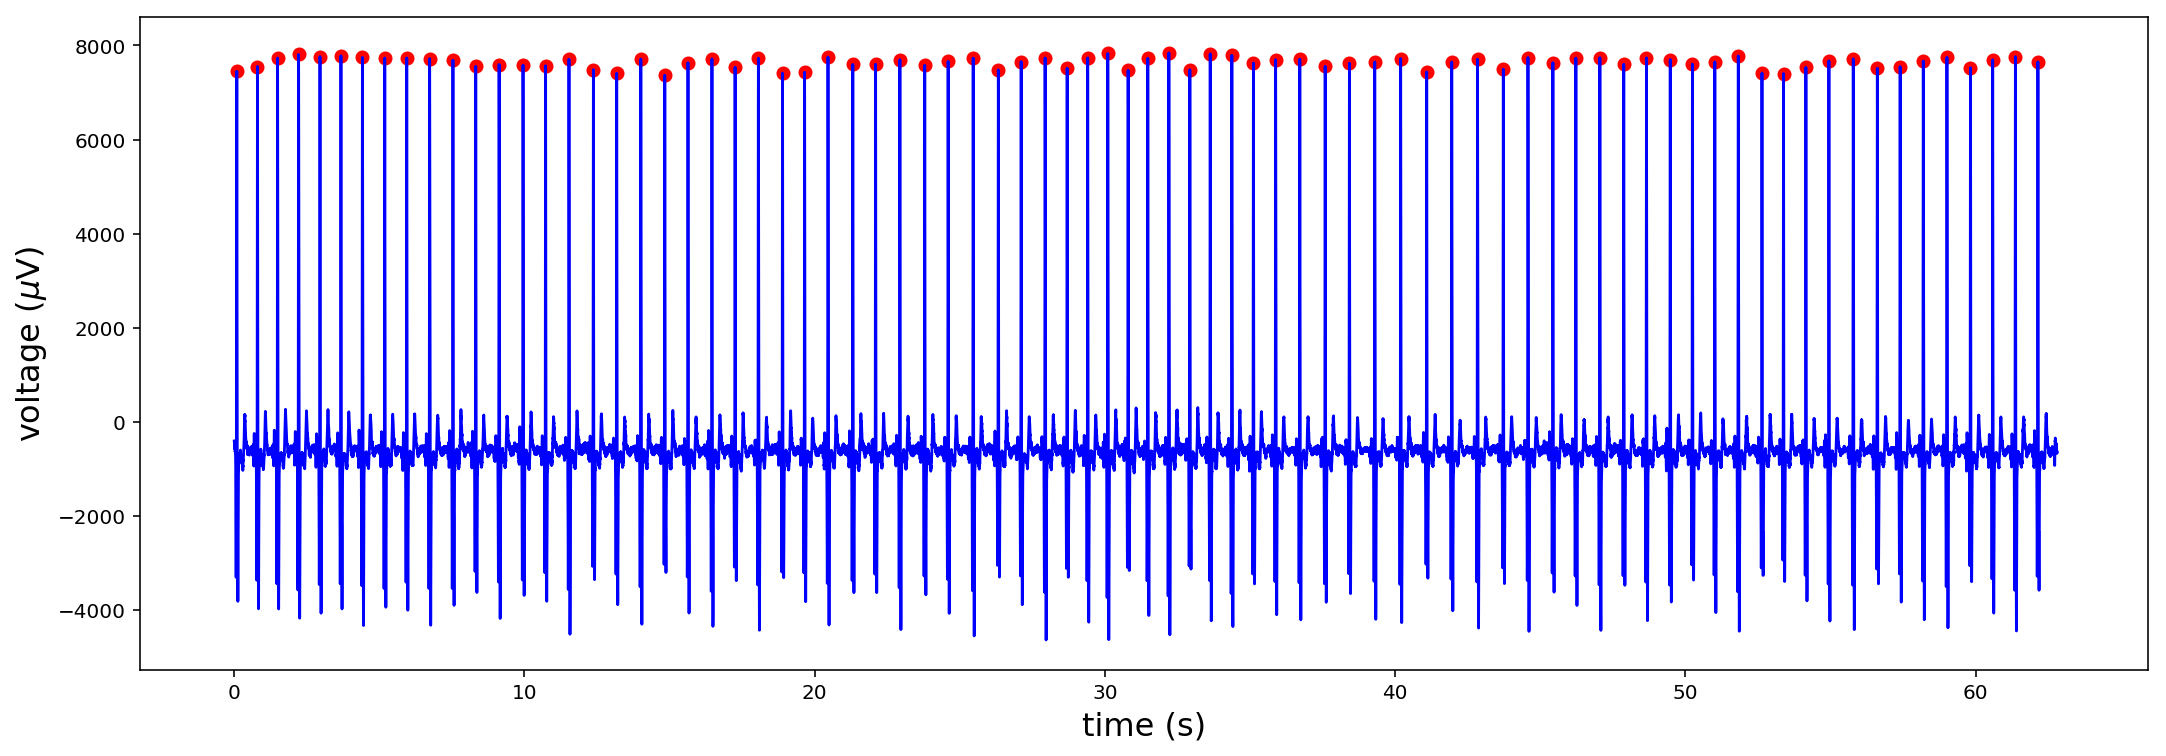

In [6]:
# Plotting ECG signal
plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.plot(timeECG_rest,waveData_rest, 'b')
plt.scatter(timeECG_rest[mxs_indices_rest], waveData_rest[mxs_indices_rest], color='r')
plt.show()

Now we use a recording of the same subject, but after performing exercise. An interesting observation is that we did not record during exercise because the equipment available to us generated several artifacts (such as movement artifacts) if the subject was not at rest. This recording will be referred to throughout the notebook as ``exer``. This is a poor election of the name, maybe a better one would have been initial recovery period.

In [8]:
timeECG_exer, waveData_exer = ecg("ECG_samples/S1_exercise.wav")
mxs_indices_exer = detecta_maximos_locales(timeECG_exer, waveData_exer)

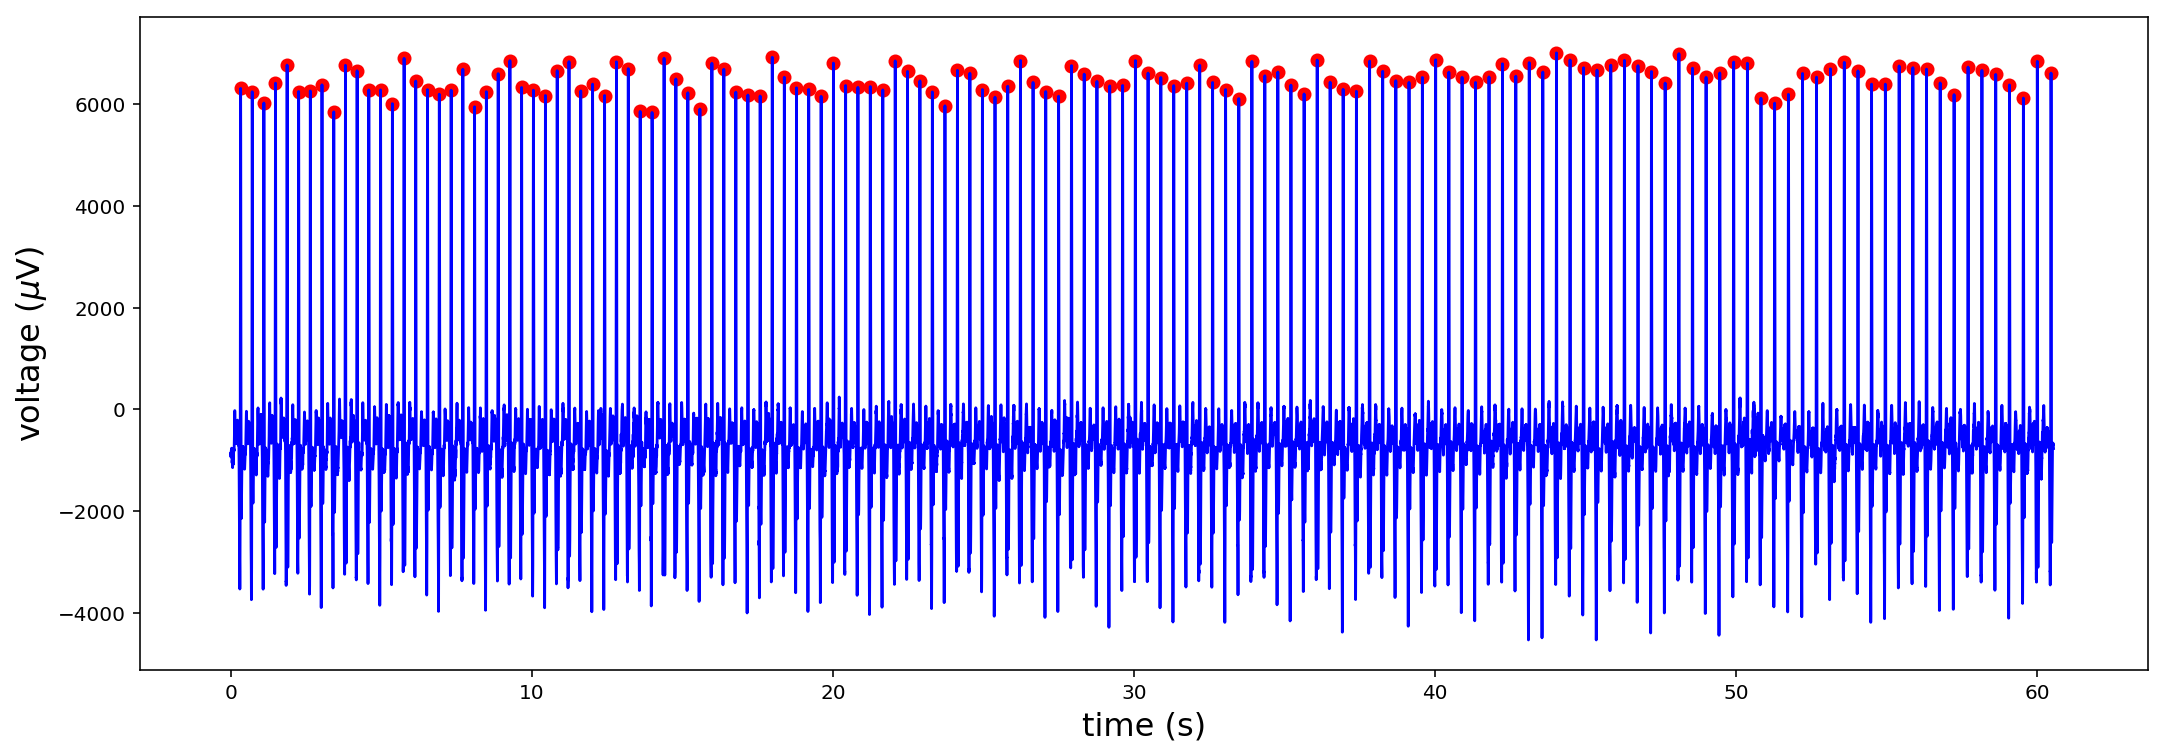

In [9]:
# Plotting ECG signal
plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.plot(timeECG_exer,waveData_exer, 'b')
plt.scatter(timeECG_exer[mxs_indices_exer], waveData_exer[mxs_indices_exer], color='r')
plt.show()

Remember that the heart frequency and the R-R intervals are complementary data. If you have one, you can obtain the other by obtaining the inverse and multiplying or dividing by 60, basically. Because of this, without loss of generality, we will do the following analysis with R-R intervals.

In [10]:
# If the input of this function is time, the intervals will be given in those same units
# Obtaining the indexes at which the R peaks occur.
def R_intervals(time_indices):
    length = len(time_indices)
    intervals = np.zeros(length-1)
    
    for i in range(0, length-1):
        intervals[i] = time_indices[i+1]-time_indices[i]
    
    return intervals

In [11]:
xx_rest = R_intervals(timeECG_rest[mxs_indices_rest])
timeRpeaks_rest = timeECG_rest[mxs_indices_rest]

mean_rr_rest = np.mean(xx_rest)
stdev_rest = stdev(xx_rest)
print("Mean R-R interval: ",mean_rr_rest)
print("Standard deviation: ",stdev_rest)

mean_vec_rest = [mean_rr_rest for i in range(0, len(timeRpeaks_rest)-1)]
std_vec_plus_rest = [mean_rr_rest + stdev_rest for i in range(0, len(timeRpeaks_rest)-1)]
std_vec_minus_rest = [mean_rr_rest - stdev_rest for i in range(0, len(timeRpeaks_rest)-1)]

Mean R-R interval:  0.7955551129613508
Standard deviation:  0.05226160016844845


In [12]:
xx_exer = R_intervals(timeECG_exer[mxs_indices_exer])
timeRpeaks_exer = timeECG_exer[mxs_indices_exer]

mean_rr_exer = np.mean(xx_exer)
stdev_exer = stdev(xx_exer)

print("Mean R-R interval: ", mean_rr_exer)
print("Standard deviation: ", stdev_exer)

mean_vec_exer = [mean_rr_exer for i in range(0, len(timeRpeaks_exer)-1)]
std_vec_plus_exer = [mean_rr_exer+stdev_exer for i in range(0, len(timeRpeaks_exer)-1)]
std_vec_minus_exer = [mean_rr_exer-stdev_exer for i in range(0, len(timeRpeaks_exer)-1)]

Mean R-R interval:  0.4234978825690435
Standard deviation:  0.02601534109626652


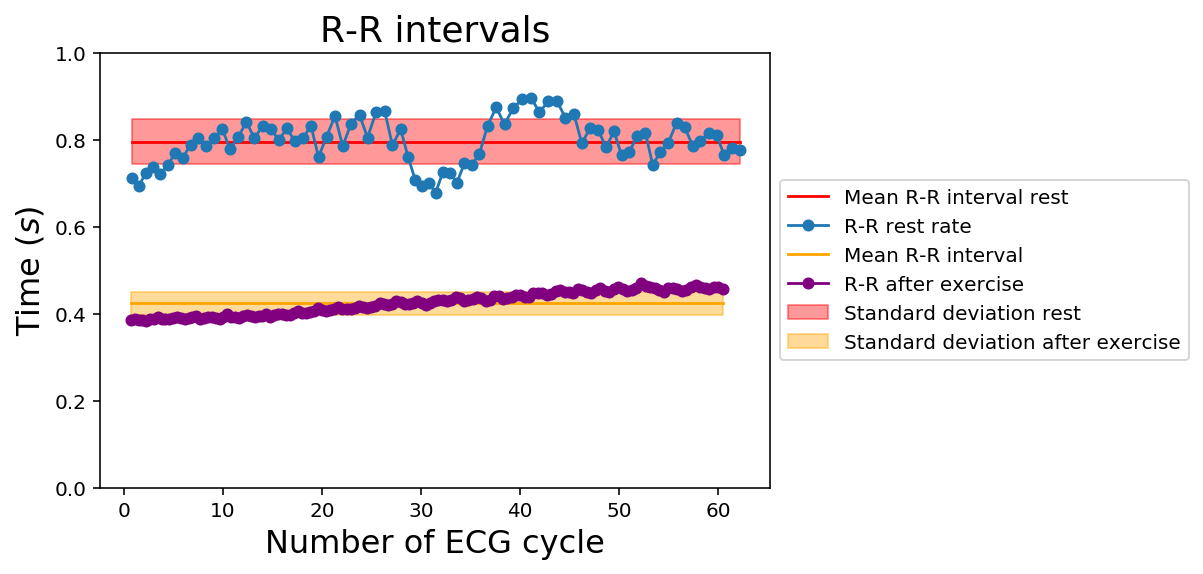

In [13]:
plt.fill_between(timeRpeaks_rest[1:], std_vec_minus_rest, std_vec_plus_rest, facecolor="red",
                 label = "Standard deviation rest", color='red', alpha=0.4)
plt.plot(timeRpeaks_rest[1:], mean_vec_rest, c="r", label = "Mean R-R interval rest")
plt.plot(timeRpeaks_rest[1:], xx_rest, markersize=5, marker = "o", label="R-R rest rate")

plt.fill_between(timeRpeaks_exer[1:], std_vec_minus_exer, std_vec_plus_exer, facecolor="orange",
                 label = "Standard deviation after exercise", color='orange', alpha=0.4)
plt.plot(timeRpeaks_exer[1:], mean_vec_exer, c="orange", label = "Mean R-R interval")
plt.plot(timeRpeaks_exer[1:], xx_exer, markersize=5, c="purple", marker = "o", label="R-R after exercise")

plt.ylim((0, 1))
plt.title("R-R intervals")
plt.xlabel(r'Number of ECG cycle')
plt.ylabel(r'Time ($s$)')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

### Exercise:
Analyze the previous graph, what can you say about the R-R intervals?

# QRS complexes

For obtaining the QRS complexes, we will find the left and right minimum values in the neighborhood of an R peak. In electrophysiology, QRS complexes start when a deviation from baseline is detected. Since we do not want to work with a fixed baseline, we are reffering to a QRS complex as the activity that happens between Q and S. Thus, the values obtained here for QRS complex will be shorter than the ones reported in the literature.

In [14]:
# Obtains 2 minimum values in the neighborhood of a certain value (entries of mxs_indices)
def local_mins(waveData, mxs_indices, n =700):
    mins_vec = []

    for R_peak_i in mxs_indices:
        left_interval = waveData[R_peak_i-n:R_peak_i]
        right_interval = waveData[R_peak_i:R_peak_i+n]

        mins_vec.append(R_peak_i - n + (list(left_interval).index(min(left_interval))) )
        mins_vec.append(R_peak_i + (list(right_interval).index(min(right_interval))) )
        
    return mins_vec

In [15]:
mins_rest = local_mins(waveData_rest, mxs_indices_rest)

# What are the lengths of these QRS complexes?
qrs_length_rest = np.zeros(len(mxs_indices_rest)-1)

for i in range(0, len(mxs_indices_rest)-1):
    qrs_length_rest[i] = timeECG_rest[mins_rest[2*i + 1]] - timeECG_rest[mins_rest[2*i]]
    
mean_qrs_rest = np.mean(qrs_length_rest)
print("Mean in seconds of the QRS complex: ",mean_qrs_rest)

vec_length_rest = len(qrs_length_rest)
std_plus_rest = mean_qrs_rest + stdev(qrs_length_rest)
std_minus_rest = mean_qrs_rest - stdev(qrs_length_rest)

mean_vec_rest = [mean_qrs_rest for i in range(0, vec_length_rest)]
std_vec_plus_rest = [std_plus_rest for i in range(0, vec_length_rest)]
std_vec_minus_rest = [std_minus_rest for i in range(0, vec_length_rest)]

Mean in seconds of the QRS complex:  0.06154625184973973


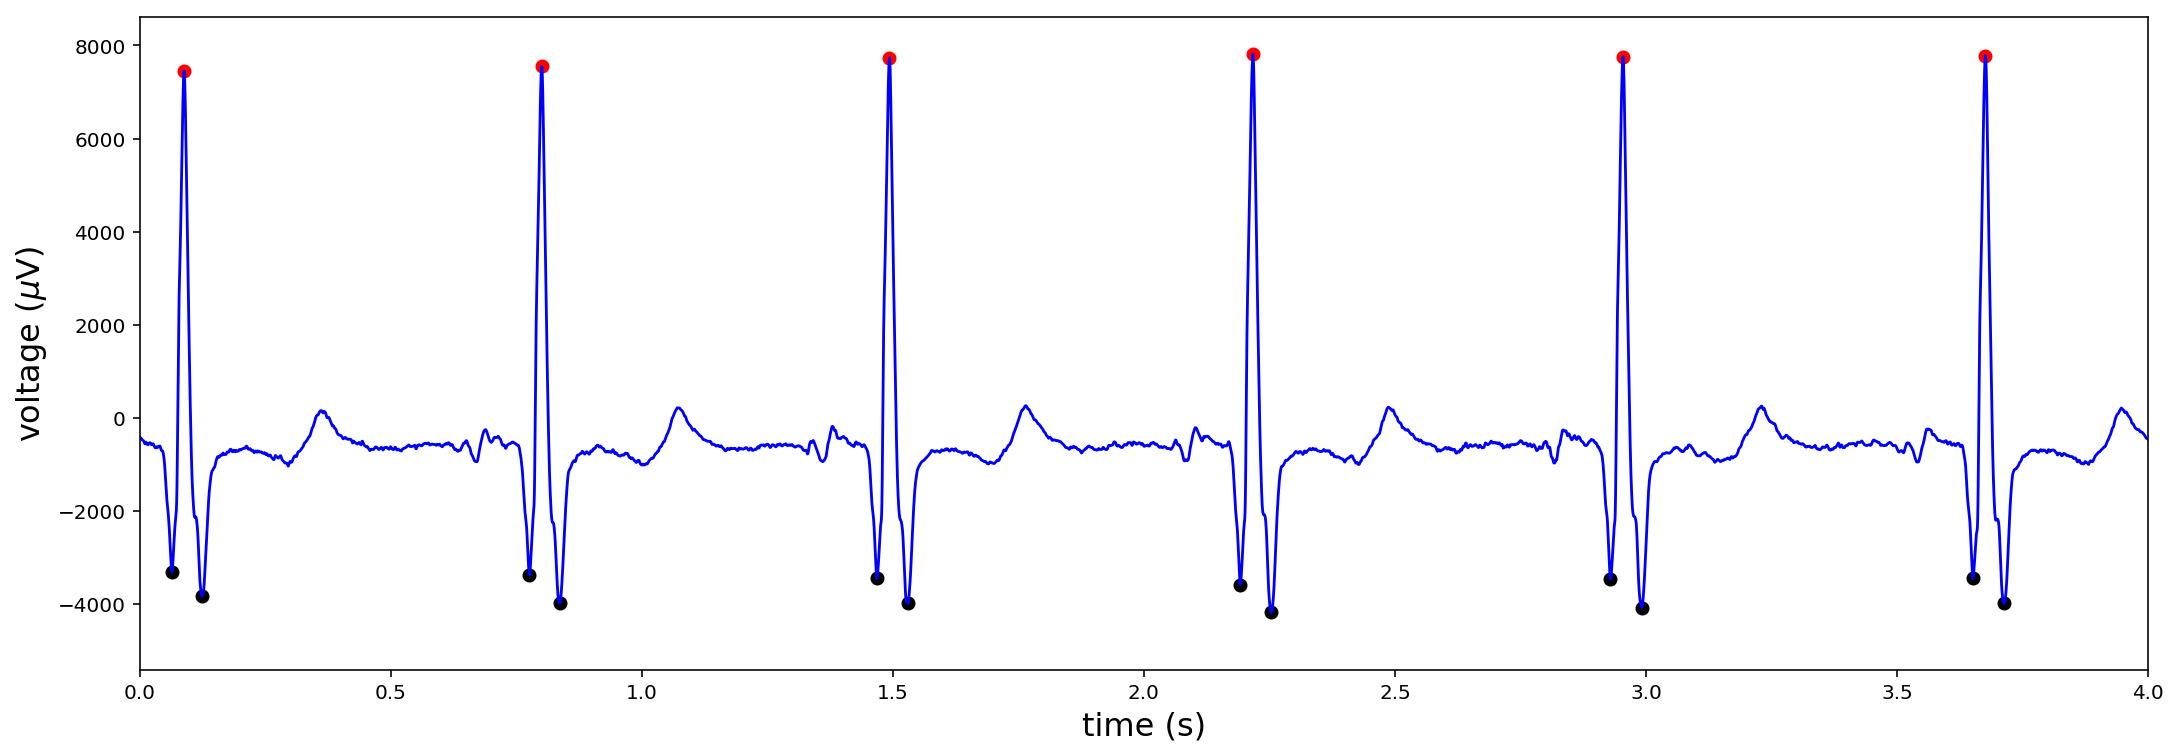

In [16]:
# Plotting
plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
# plt.xlim(min(timeECG_rest), max(timeECG_rest))
plt.xlim(0, 4)

plt.plot(timeECG_rest, waveData_rest, 'b')
plt.scatter(timeECG_rest[mxs_indices_rest], waveData_rest[mxs_indices_rest], color='r')
plt.scatter(timeECG_rest[mins_rest], waveData_rest[mins_rest], color='k')
plt.show()

In [17]:
mins_exer = local_mins(waveData_exer, mxs_indices_exer)
qrs_length_exer = np.zeros(len(mxs_indices_exer)-1)

for i in range(0, len(mxs_indices_exer)-1):
    qrs_length_exer[i] = timeECG_exer[mins_exer[2*i + 1]] - timeECG_exer[mins_exer[2*i]]
    
mean_qrs_exer = np.mean(qrs_length_exer)
print("Mean in seconds of the QRS complex: ",mean_qrs_exer)

vec_length_exer = len(qrs_length_exer)
std_plus_exer = mean_qrs_exer + stdev(qrs_length_exer)
std_minus_exer = mean_qrs_exer - stdev(qrs_length_exer)

mean_vec_exer = [mean_qrs_exer for i in range(0, vec_length_exer)]
std_vec_plus_exer = [std_plus_exer for i in range(0, vec_length_exer)]
std_vec_minus_exer = [std_minus_exer for i in range(0, vec_length_exer)]

Mean in seconds of the QRS complex:  0.05079304163882738


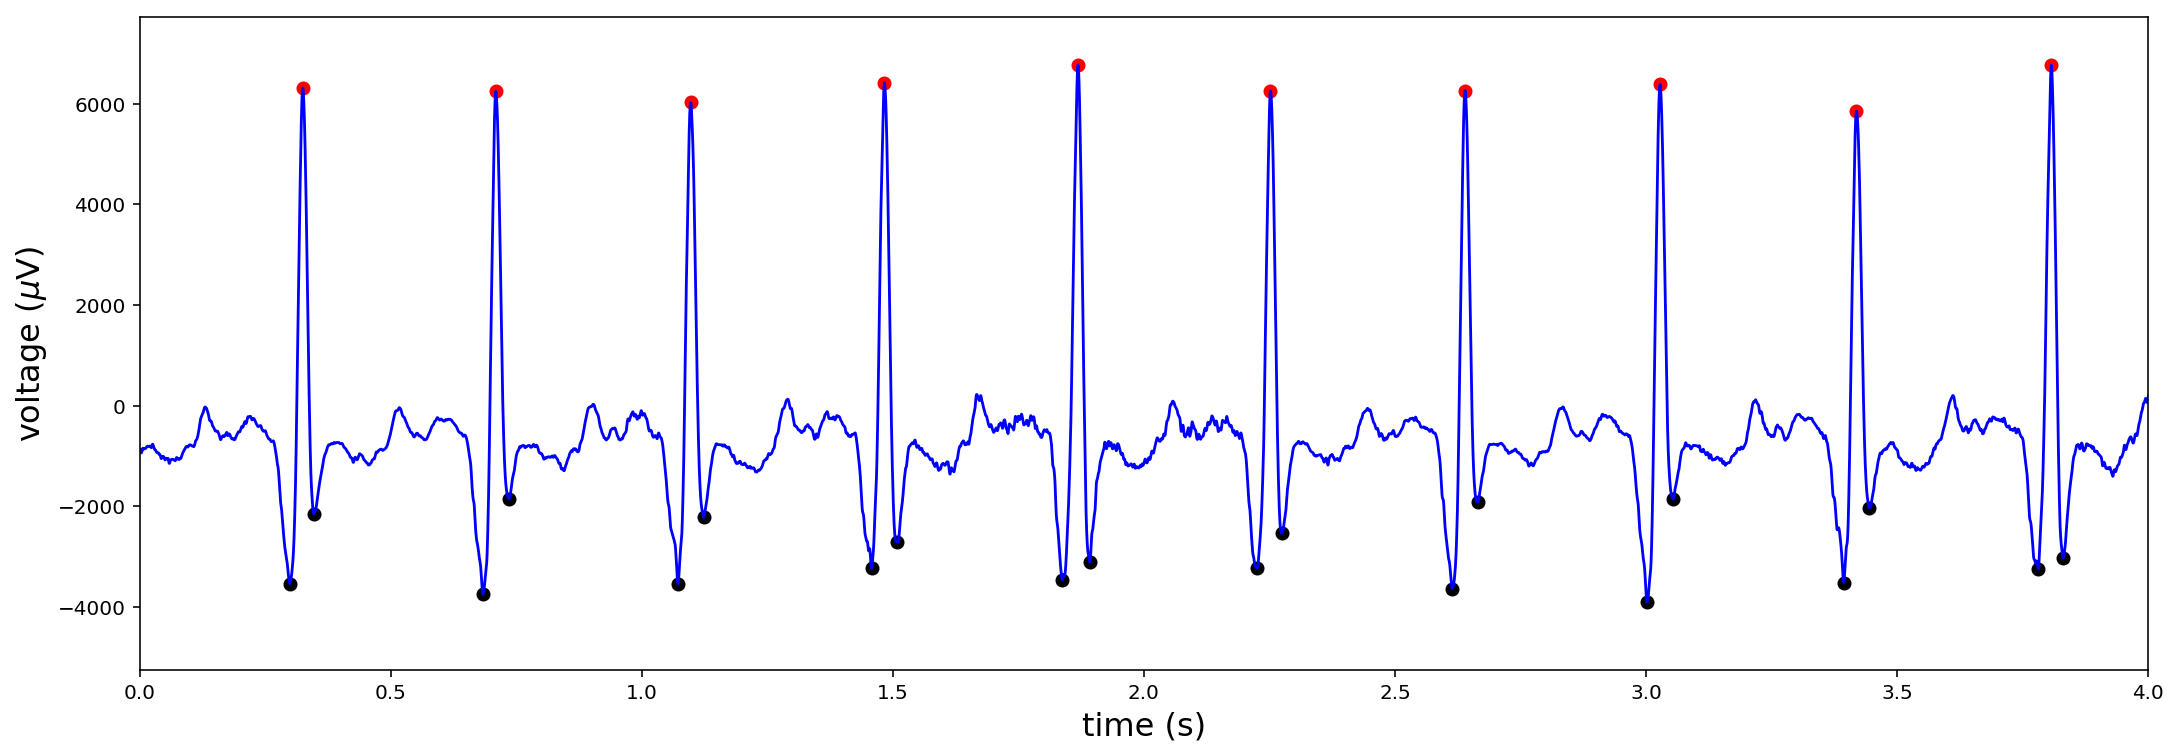

In [18]:
# Plotting the exercise
plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
# plt.xlim(min(timeECG_exer),max(timeECG_exer))
plt.xlim(0, 4)

plt.plot(timeECG_exer,waveData_exer, 'b')
plt.scatter(timeECG_exer[mxs_indices_exer], waveData_exer[mxs_indices_exer], color='r')
plt.scatter(timeECG_exer[mins_exer], waveData_exer[mins_exer], color='k')
plt.show()

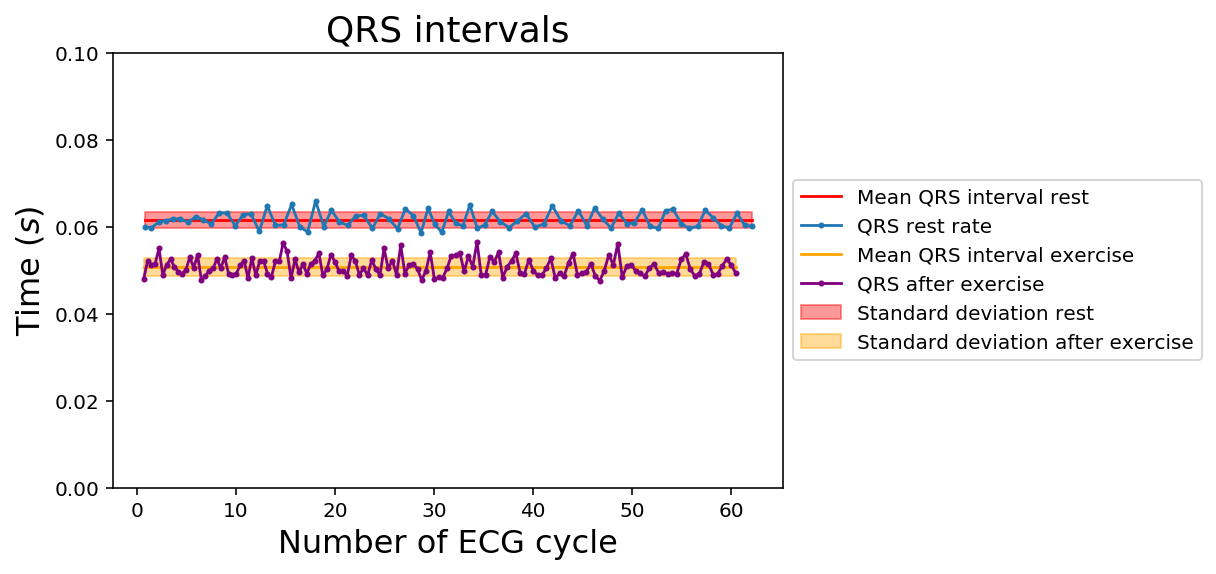

In [19]:
plt.fill_between(timeRpeaks_rest[1:], std_vec_minus_rest, std_vec_plus_rest, facecolor="red",
                 label = "Standard deviation rest", color='red', alpha=0.4)
plt.plot(timeRpeaks_rest[1:], mean_vec_rest, c="r", label = "Mean QRS interval rest")
plt.plot(timeRpeaks_rest[1:], qrs_length_rest, markersize=2, marker = "o", label="QRS rest rate")

plt.fill_between(timeRpeaks_exer[1:], std_vec_minus_exer, std_vec_plus_exer, facecolor="orange",
                 label = "Standard deviation after exercise", color='orange', alpha=0.4)
plt.plot(timeRpeaks_exer[1:], mean_vec_exer, c="orange", label = "Mean QRS interval exercise")
plt.plot(timeRpeaks_exer[1:], qrs_length_exer, markersize=2, c="purple", marker = "o", label="QRS after exercise")

plt.ylim((0, 0.1))
plt.title("QRS intervals")
plt.xlabel(r'Number of ECG cycle')
plt.ylabel(r'Time ($s$)')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

### Why are we observing a change in the QRS interval? Is it not a constant value?

# Poincaré plots

We already have the ``mxs_indices`` which correspond to the R-peaks, and ``xx`` corresponds to the R intervals.. With this information, we can make a plot where we compare each one of these peaks to the next one.

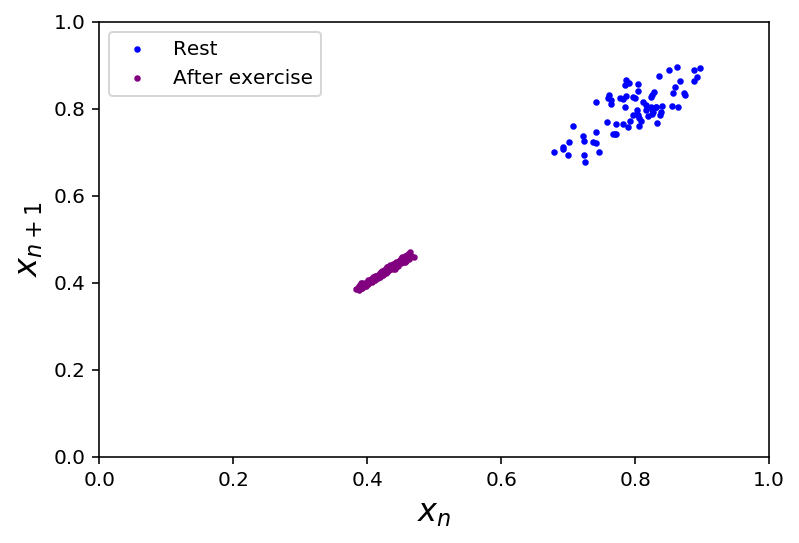

In [21]:
plt.scatter(xx_rest[1:-1], xx_rest[:-2], s = 5, c = "blue", label = "Rest")
plt.scatter(xx_exer[1:-1], xx_exer[:-2], s = 5, c ="purple", label = "After exercise")
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel(r"$x_n$")
plt.ylabel(r"$x_{n+1}$")
plt.legend()
plt.show()

### Exercise: Compare the two patterns. Why do we see the points getting closer and near the origin after performing exercise?

Notice that in this technique we are using only the R-R interval time series. The points at rest seem more disperse than after performing exercise. This is generally observed in healthy hearts. If you are particularly interested in this technique, you can see the following book:

Khandoker, A. H., Karmakar, C., Brennan, M., Palaniswami, M., & Voss, A. (2013). Poincaré plot methods for heart rate variability analysis. Boston, MA, USA: Springer US.

# Phase space reconstruction

In the previos technique we only compared the R intervals with the next interval. What would happen if we compare not the R interval, but the whole recording with a certain time delay we choose. Instead of comparing one data point with its next in time, what would happen if we choose an arbitrary time delay? In other words, we are going to generalize what we applied in the previous technique with the whole ECG data series and with an arbitrary time delay.

In [22]:
#Generating a function that will reconstruct the phase space for a certain time delay
# data_series is the voltage of our signal
# period is the time delay
# identifier is a string that will help us identify that particular graph

def graph_phase_space(waveData, period = 210, identifier = "xx"):
    time = period*0.1 #time is in miliseconds
    n = np.size(waveData) #size of the voltage vector
    
    plt.figure(2)
    plt. plot(waveData[0: n-period], waveData[period: n],
              marker = "o", markersize = 0.05, linewidth = 0.005, color = "black")
    plt.title(identifier+r": $t+"+str(time)+"ms$")
    plt.xlabel(r"$x_n$")
    y = r'$x_{n+'+str(time)+"ms}$"
    plt.ylabel(y)
    plt.show()
    return None

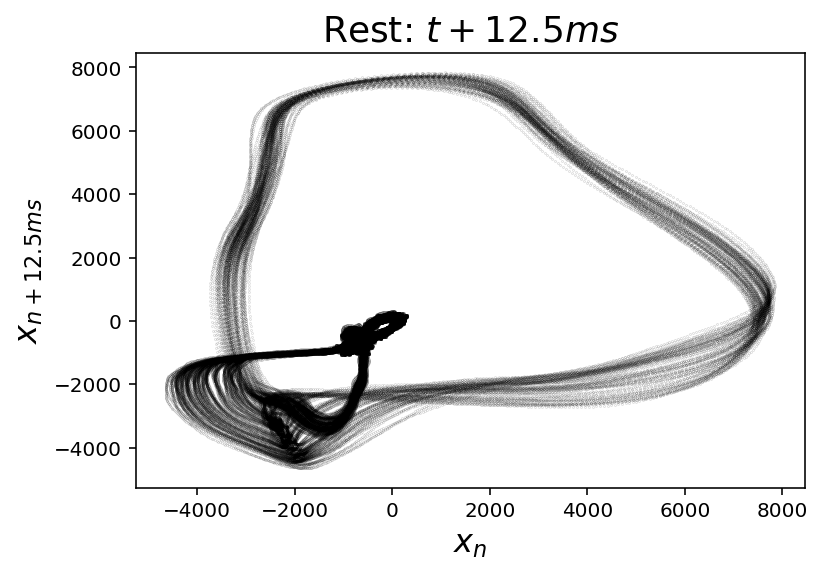

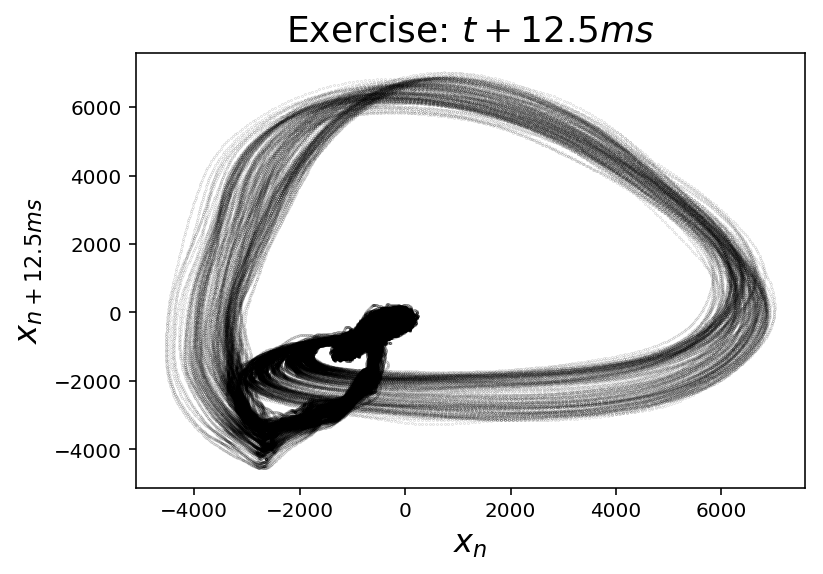

In [23]:
time_delay = 125 #12.5 ms

graph_phase_space(waveData_rest, time_delay, identifier = "Rest")
graph_phase_space(waveData_exer, time_delay, identifier = "Exercise")

### Exercise: Choose another time delay and make the graphs. What can you say about this technique?

### Exercise: Are the results obtained in a Poincaré plot and in a recurrence plot contradictory? While we are observing a loss in the first plot's variability with exercise, we are seeing the opposite in a recurrence plot. Why?

# Recurrence plots

This is a technique which compares every single data point to every other. Because of this reason, it is a very expensive algorithm computationaly. To reduce this computational time, we must create a surrogate data set. Be sure to create a surrogate data set that includes at least two QRS complexes.

In the following cell, change the start and end values to obtain two QRS complexes.

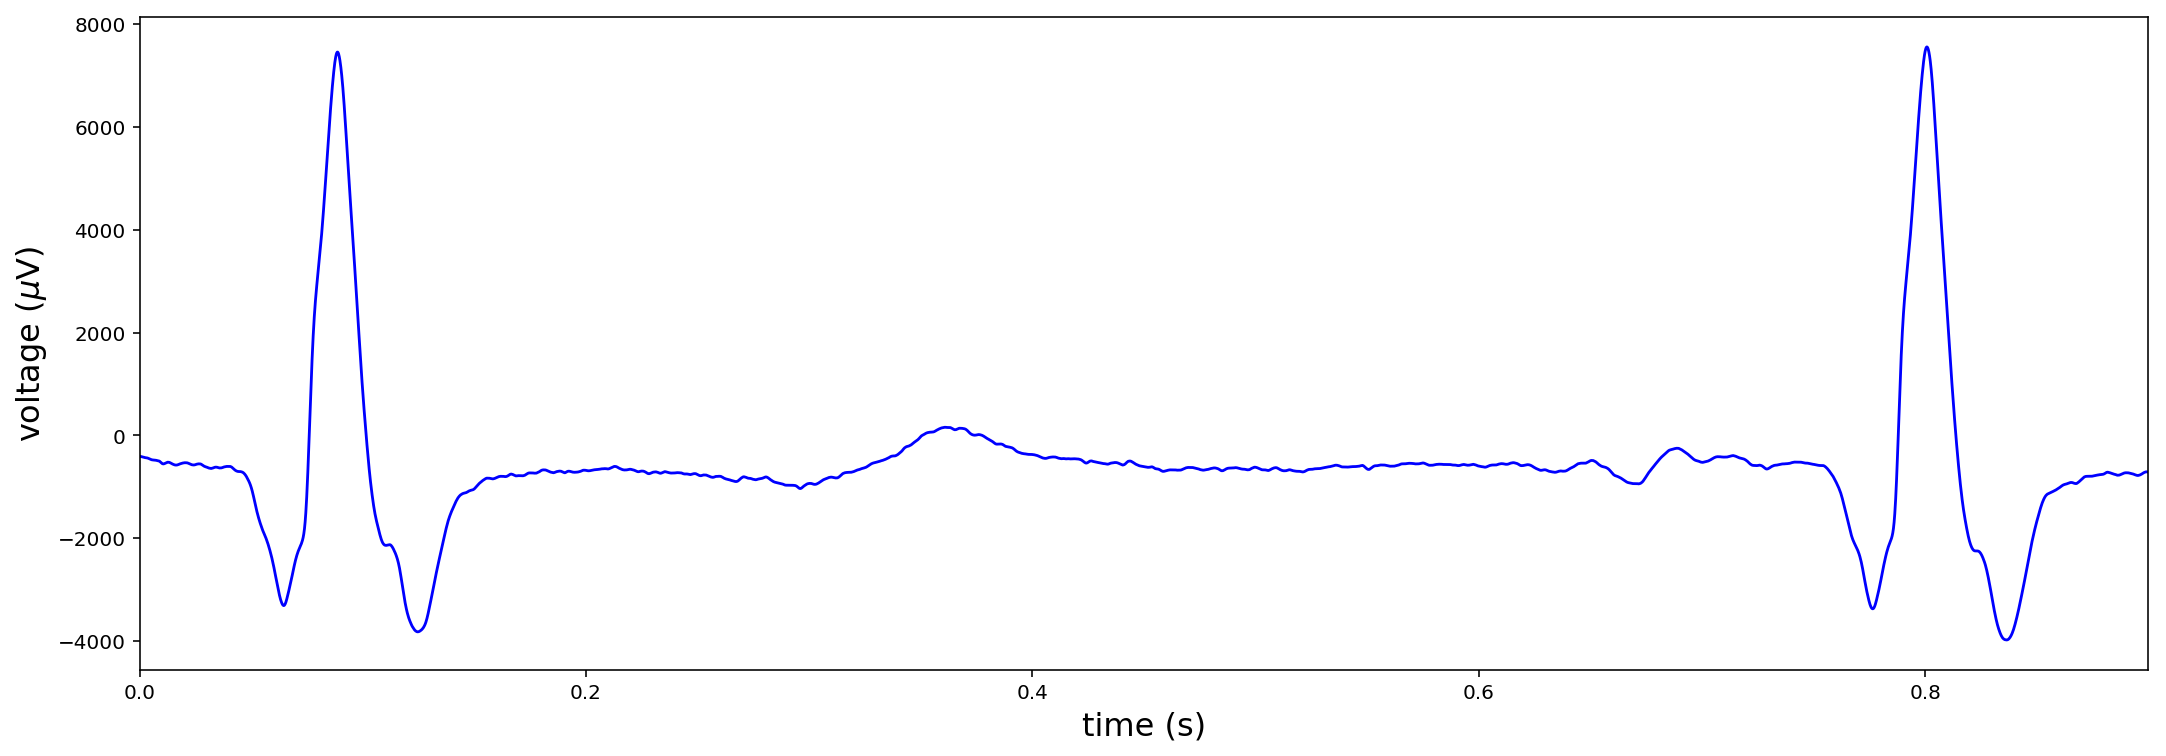

In [24]:
# Plotting
start = 0
end = 9000

plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.xlim(timeECG_rest[start], timeECG_rest[end])

plt.plot(timeECG_rest[start:end], waveData_rest[start:end], 'b')
plt.show()

In [25]:
# Function for creating the surrogate time series
def surrogate(timeECG, waveData, start, end):
    surrogate = [waveData[start+i*5] for i in range(0, int((end-start)/5))]
    time_surrogate = [timeECG[start+i*5] for i in range(0, int((end-start)/5))]
    
    print("Sampling rate of ", len(waveData)/timeECG[-1],
          " points per second got reduced to ", len(time_surrogate)/time_surrogate[-1],
         " points per second.")
    
    print("Time series of ",len(timeECG[start:end])," got reduced to ",len(time_surrogate))
    
    plt.plot(time_surrogate, surrogate, marker="o", c="r")
    plt.show()
    
    return [time_surrogate, surrogate]

Sampling rate of  10000.0  points per second got reduced to  2001.1085422545434  points per second.
Time series of  9000  got reduced to  1800


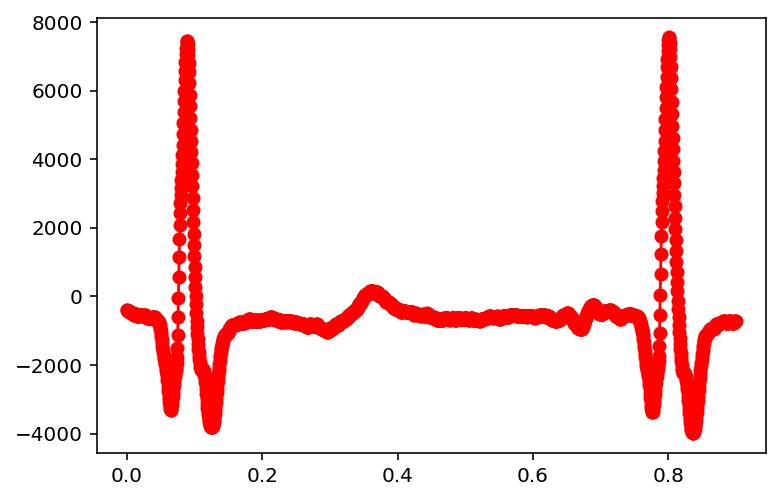

In [26]:
start = 0
end = 9000

time_surrogate_rest, surrogate_rest = surrogate(timeECG_rest, waveData_rest, start, end)

Now we will reconstruct the attractor just like in the previous exercise, but only with this surrogate tiem series. First, we choose a delay just like in the previous exercise, for example $delay=12.5 ms$. We must find the number of data poitns that correspond to this time delay.

In [27]:
data_point_delay = 25
delay = time_surrogate_rest[data_point_delay]-time_surrogate_rest[0]
print(delay)

0.012500019904490293


Perfect! Now let's reconstruct the attractor.

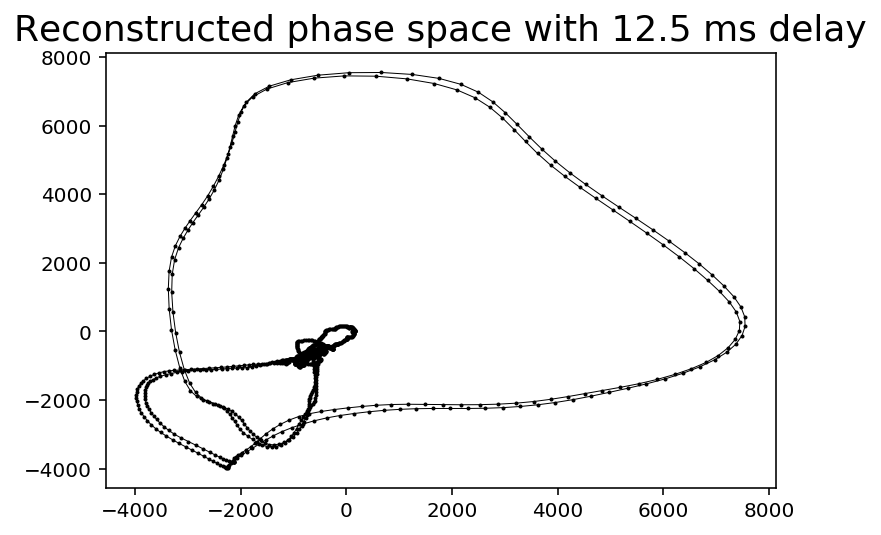

In [28]:
# Reconstructing the attractor
n = np.size(surrogate_rest)
plt.plot(surrogate_rest[0: n-data_point_delay], surrogate_rest[data_point_delay: n],
          marker = "o", markersize = 1, linewidth = 0.5, color = "black")
plt.title("Reconstructed phase space with 12.5 ms delay")
plt.show()

Now, we create the recurrence plot.

In [29]:
# Heat map Recurrence plot
def recurrence_plot(surrogate, data_point_delay = 25):
    n = len(surrogate)
    euclid = np.zeros((n,n), dtype = 'float')
    normal_euclid = np.zeros((n,n), dtype = 'float')

    #Cycle for obtaining the euclid distance between any two points
    for i in range(0, n-data_point_delay):
        for j in range(data_point_delay, n):
            euclid[i][j] = np.sqrt(np.abs(surrogate[i]**2 - surrogate[j]**2)) #euclidian norm

    normal_aux = np.max(euclid)

    # Cycle for normalizing the distance
    for i in range(0, n-data_point_delay):
        for j in range(data_point_delay, n):
            normal_euclid[i][j] = np.abs(euclid[i][j]/normal_aux-1)
            #Normalizing the values, and the farthest points have the lowest value (0),
            #while the nearest points have a value near 1

    return normal_euclid

In [30]:
normal_euclid_rest = recurrence_plot(surrogate_rest, 25)

#Creating a vector with the indices for the surrogate data
index_surrogate_rest = [i for i in range(0, len(surrogate_rest))]

In [41]:
def graph_recurrence(surrogate_data, index_surrogate, normal_euclid):
    #Initializing the graphic space
    fig = plt.figure(figsize=(6,8))
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[2, 1], wspace=0.2, hspace=0.3)
    ax1 = fig.add_subplot(gs[1, 0])
    ax2 = fig.add_subplot(gs[0, 0], sharex=ax1)
    plt.tick_params(which='both', top=False, right=False)
    ax2.set_autoscalex_on(False)

    # Electrocardiogram
    ax1.set_title("Electrocardiogram")
    ax1.set_ylabel('Voltage')
    ax1.set_xlabel('Index')
    ax1.set_xlim(0, len(surrogate_data))
    ax1.plot(index_surrogate, surrogate_data, marker="o", c="k") #index_surrogate or time_surrogate (ms)

    # Reconstructed attractor in phase space
    # ax1.plot(surrogate[0: n-delay], surrogate[delay: n],
    #           marker = "o", markersize = 0.05, linewidth = 0.005, color = "black")

    # Recurrence plot
    ax2.set_title("Recurrence plot")
    ax2.set_ylabel('Index')
    ax2.set_xlabel('Index')
    plot = ax2.imshow(normal_euclid, origin='lower', aspect="auto", cmap="jet")
    axins = inset_axes(ax2,
                   width="5%", # width = 10% of parent_bbox width
                   height="100%", # height : 50%
                   loc=6,
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=0,)

    cbar = plt.colorbar(plot, cax=axins)
    plt.show()
    return None

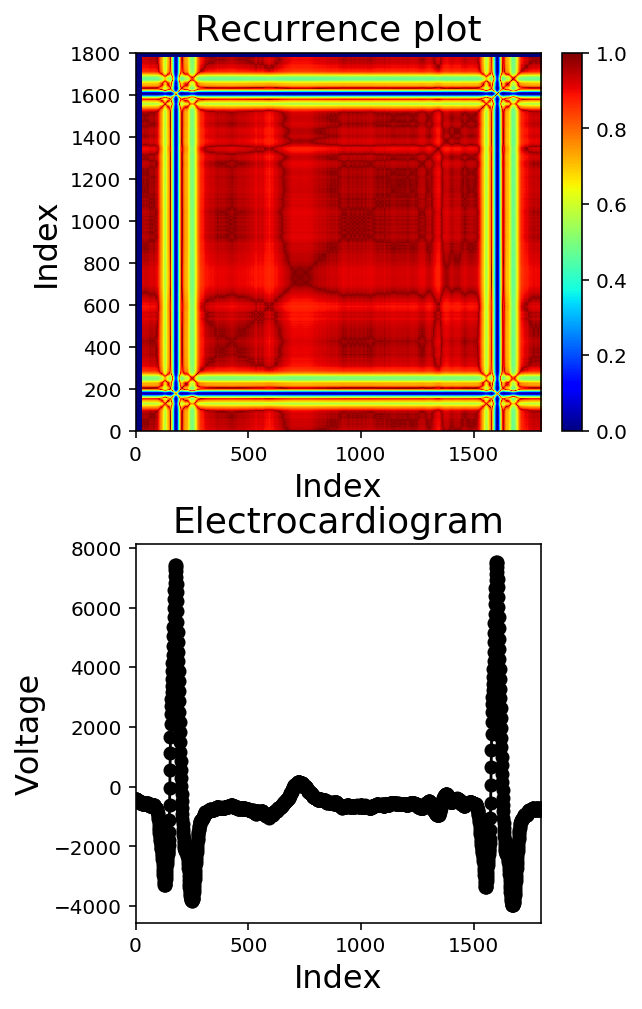

In [42]:
graph_recurrence(surrogate_rest, index_surrogate_rest, normal_euclid_rest)

Now let's do the previous for the after exercise data and make use of the functions we already defined.

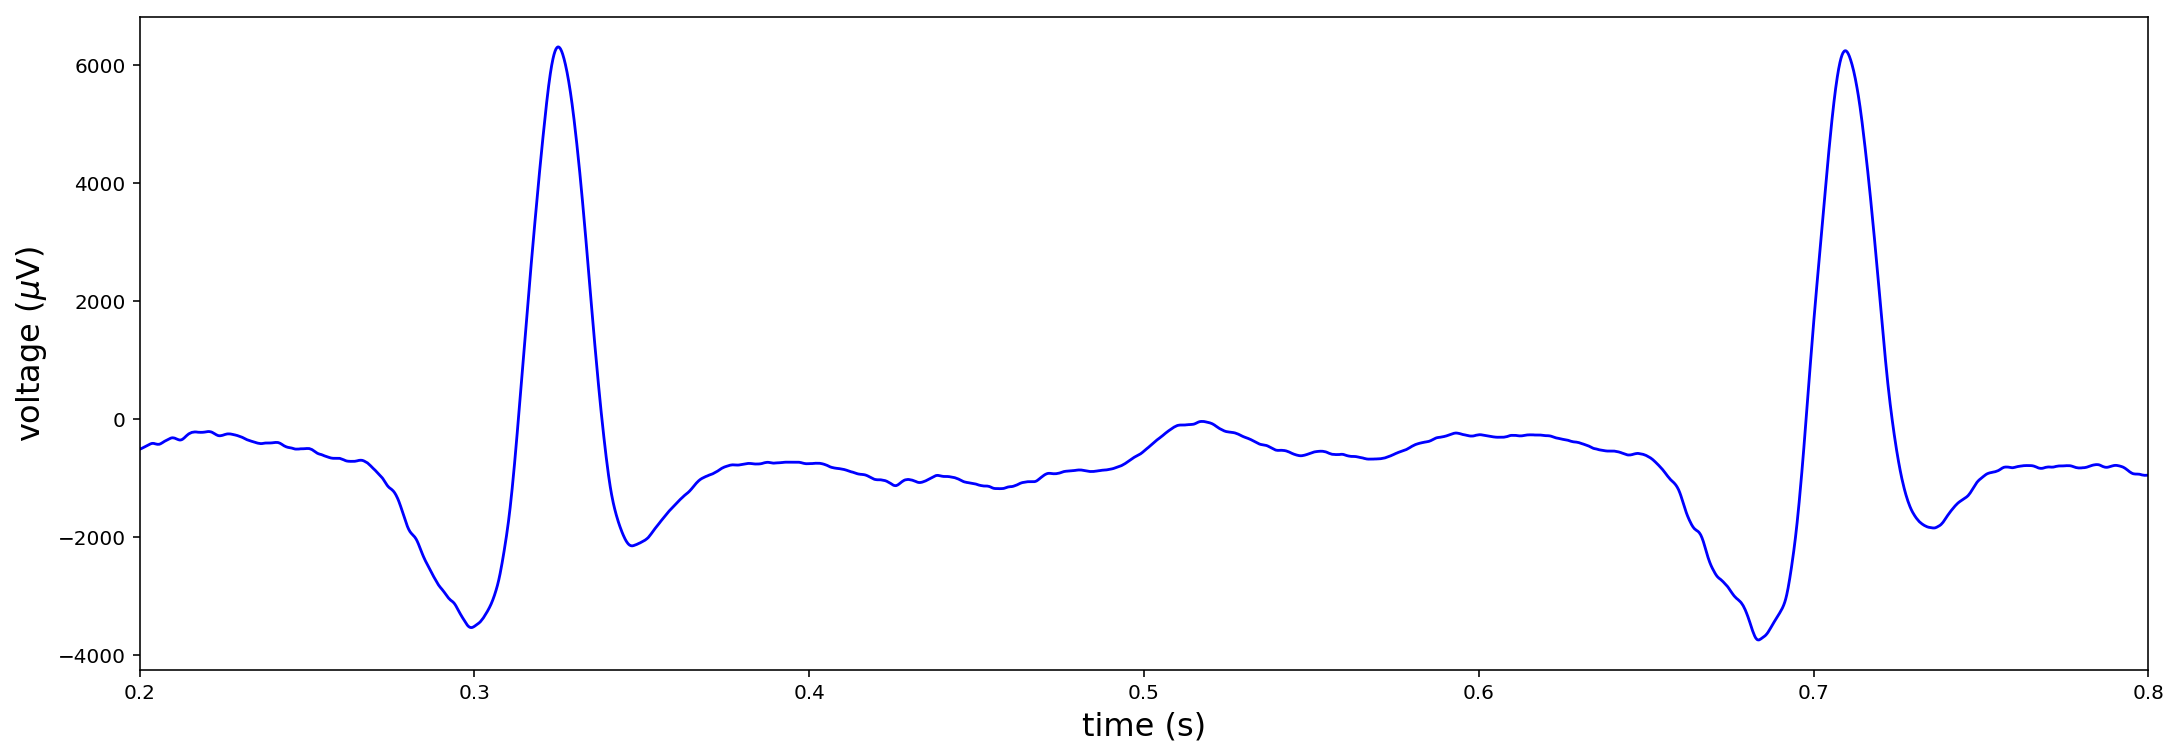

In [43]:
# Plotting
start = 2000
end = 8000

plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.xlim(timeECG_exer[start], timeECG_exer[end])

plt.plot(timeECG_exer[start:end], waveData_exer[start:end], 'b')
plt.show()

Sampling rate of  10000.0  points per second got reduced to  1500.935607278932  points per second.
Time series of  6000  got reduced to  1200


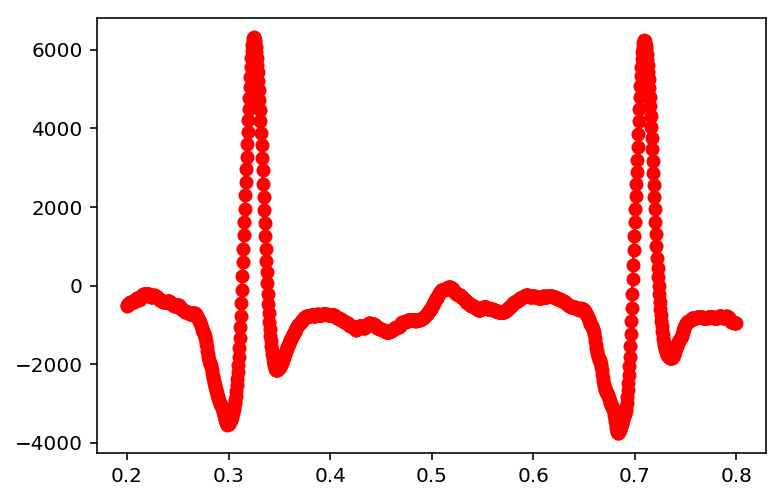

In [44]:
time_surrogate_exer, surrogate_exer = surrogate(timeECG_exer, waveData_exer, start, end)

In [45]:
data_point_delay = 25
delay = time_surrogate_exer[data_point_delay]-time_surrogate_exer[0]
print(delay)

0.012500020645664245


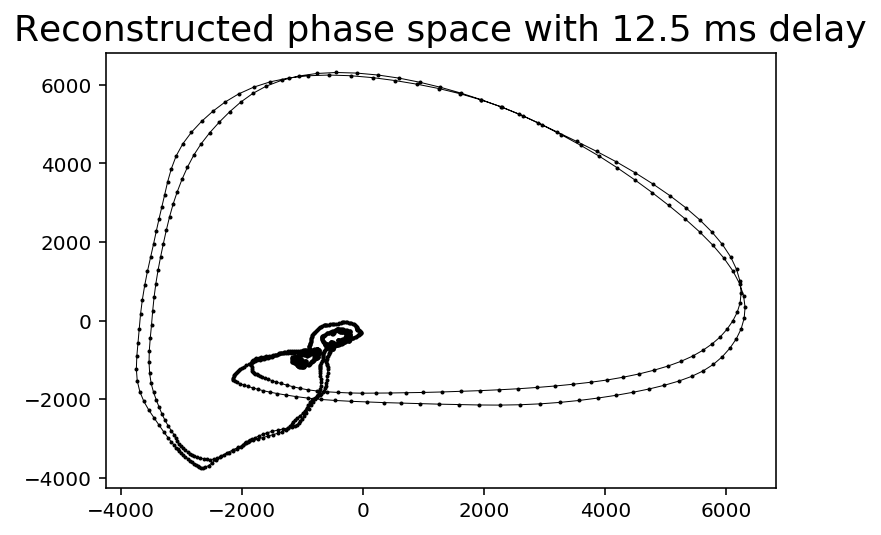

In [46]:
# Reconstructing the attractor
n = np.size(surrogate_exer)
plt.plot(surrogate_exer[0: n-data_point_delay], surrogate_exer[data_point_delay: n],
          marker = "o", markersize = 1, linewidth = 0.5, color = "black")
plt.title("Reconstructed phase space with 12.5 ms delay")
plt.show()

In [47]:
normal_euclid_exer = recurrence_plot(surrogate_exer, 25)

#Creating a vector with the indices for the surrogate data
index_surrogate_exer = [i for i in range(0, len(surrogate_exer))]

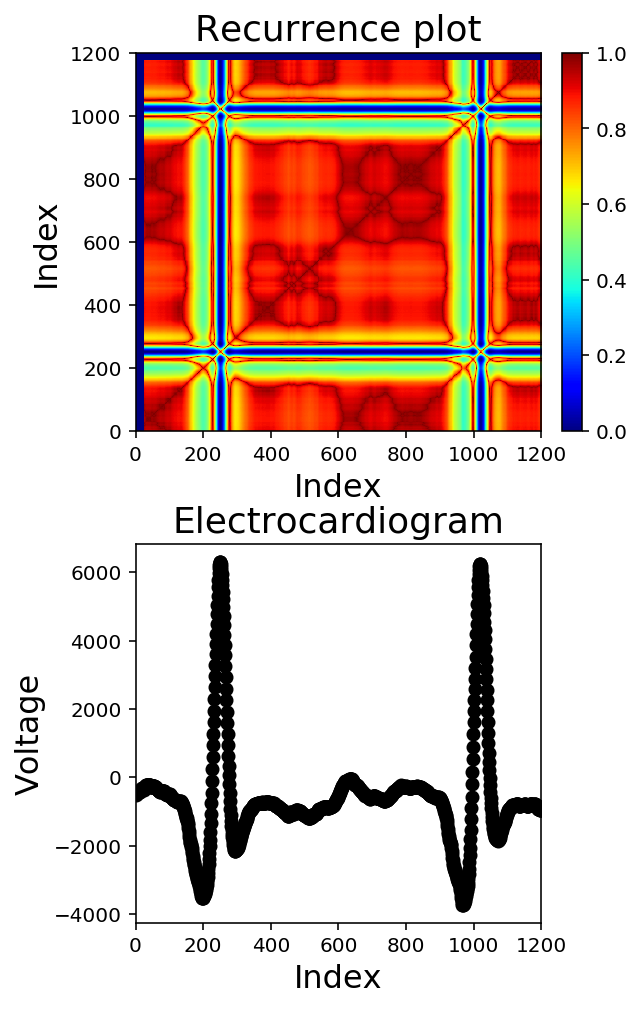

In [48]:
graph_recurrence(surrogate_exer, index_surrogate_exer, normal_euclid_exer)

Let's visualize side by side in this technique the comparison with rest or after exercise.

In [ ]:
    #Initializing the graphic space
    fig = plt.figure(figsize=(6,8))
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[2, 1], wspace=0.2, hspace=0.3)
    ax1 = fig.add_subplot(gs[1, 0])
    ax2 = fig.add_subplot(gs[0, 0], sharex=ax1)
    plt.tick_params(which='both', top=False, right=False)
    ax2.set_autoscalex_on(False)

    # Electrocardiogram
    ax1.set_title("Electrocardiogram")
    ax1.set_ylabel('Voltage')
    ax1.set_xlabel('Index')
    ax1.set_xlim(0, len(surrogate_data))
    ax1.plot(index_surrogate, surrogate_data, marker="o", c="k") #index_surrogate or time_surrogate (ms)

    # Reconstructed attractor in phase space
    # ax1.plot(surrogate[0: n-delay], surrogate[delay: n],
    #           marker = "o", markersize = 0.05, linewidth = 0.005, color = "black")

    # Recurrence plot
    ax2.set_title("Recurrence plot")
    ax2.set_ylabel('Index')
    ax2.set_xlabel('Index')
    plot = ax2.imshow(normal_euclid, origin='lower', aspect="auto", cmap="jet")
    axins = inset_axes(ax2,
                   width="5%", # width = 10% of parent_bbox width
                   height="100%", # height : 50%
                   loc=6,
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=0,)

    cbar = plt.colorbar(plot, cax=axins)
    plt.show()


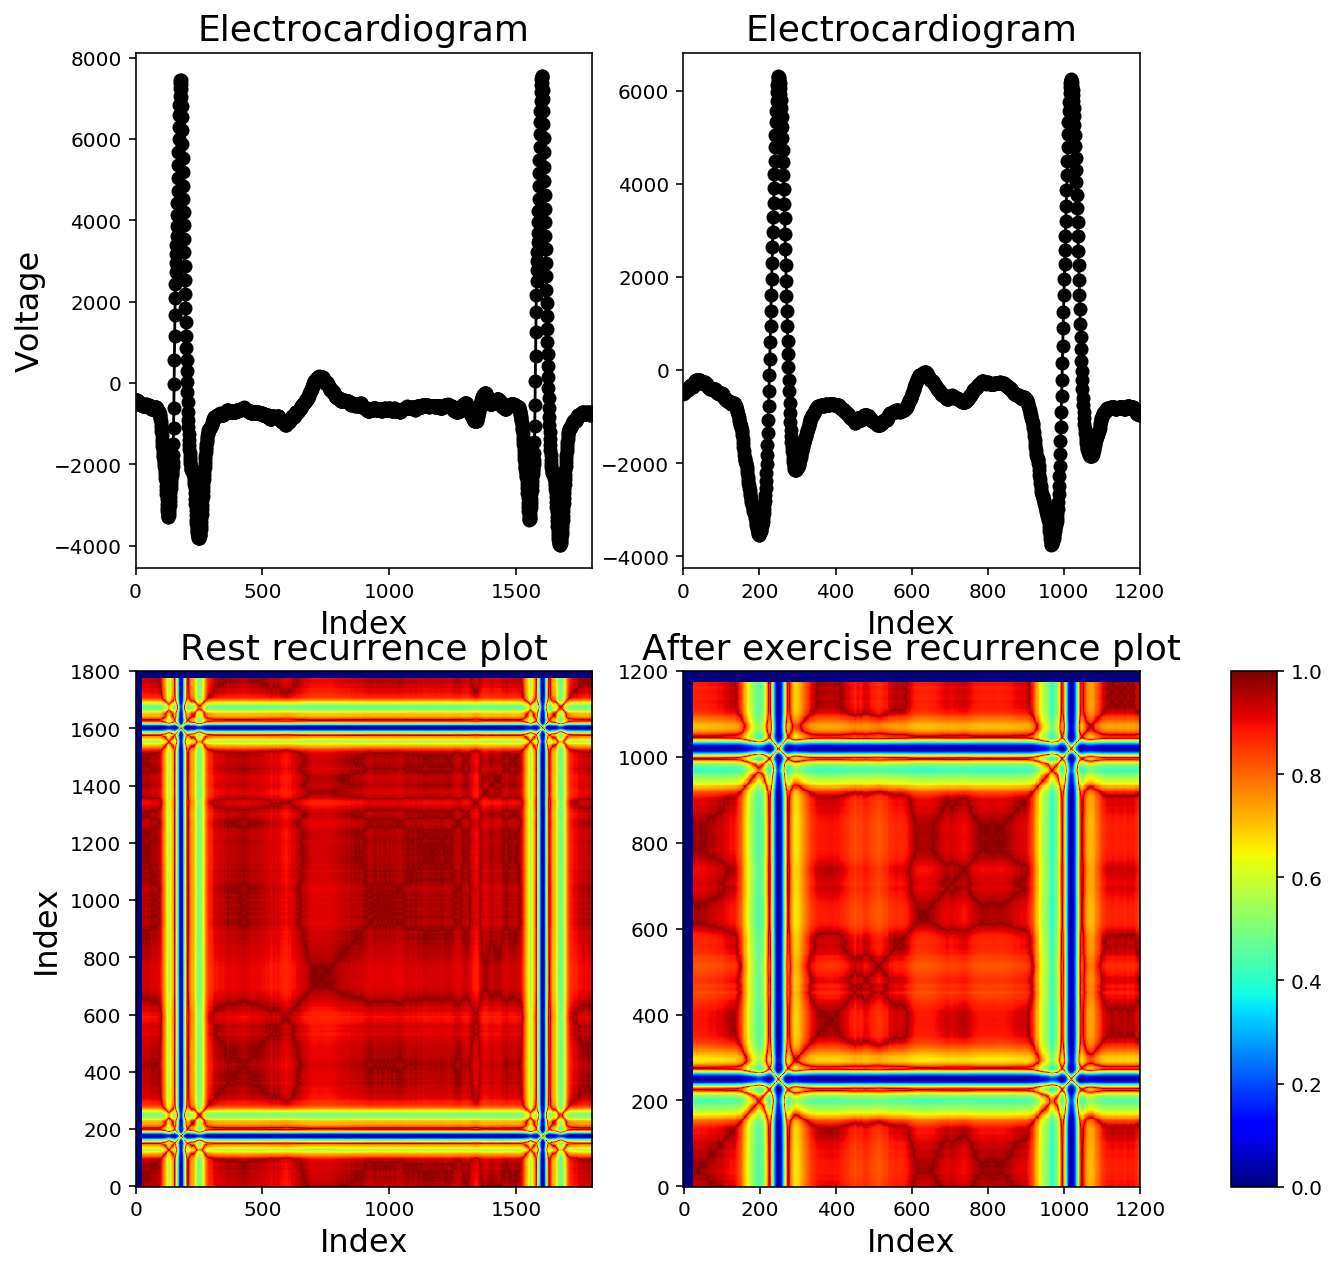

In [62]:
fig, axs = plt.subplots(2,2,figsize=(9,9))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1], wspace=0.2, hspace=0.3)

axs[0, 0].plot(index_surrogate_rest, surrogate_rest, marker="o", c="k")
axs[0, 0].set_title("Electrocardiogram")
axs[0, 0].set_xlabel("Index")
axs[0, 0].set_ylabel("Voltage")
axs[0, 0].set_xlim(0, len(index_surrogate_rest))

axs[0, 1].plot(index_surrogate_exer, surrogate_exer, marker="o", c="k")
axs[0, 1].set_title("Electrocardiogram")
axs[0, 1].set_xlabel("Index")
axs[0, 1].set_xlim(0, len(index_surrogate_exer))

plot = axs[1, 0].imshow(normal_euclid_rest, origin='lower', aspect="auto", cmap="jet")
axs[1, 0].set_title("Rest recurrence plot")
axs[1, 0].set_xlabel("Index")
axs[1, 0].set_ylabel("Index")
axins = inset_axes(axs[1,0],
               width="10%", # width = 10% of parent_bbox width
               height="100%", # height : 50%
               loc=6,
               bbox_to_anchor=(2.4, 0, 1, 1),
               bbox_transform=axs[1,0].transAxes,
               borderpad=0,)

axs[1, 1].imshow(normal_euclid_exer, origin='lower', aspect="auto", cmap="jet")
axs[1, 1].set_title("After exercise recurrence plot")
axs[1, 1].set_xlabel("Index")

cbar = plt.colorbar(plot, cax=axins)
fig.subplots_adjust(top=1)